In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import pandas as pd
import numpy as np
import fastai
import seaborn as sns

from pathlib import Path
from fastai.tabular.all import *
from sklearn.metrics import r2_score

In [3]:
path = Path('/kaggle/input/pima-indians-diabetes-database')
path.ls()

(#1) [Path('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')]

In [4]:
train = pd.read_csv(path/'diabetes.csv')
train


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
train.head().T

,0,1,2,3,4
Pregnancies,6.000,1.000,8.000,1.000,0.000
Glucose,148.000,85.000,183.000,89.000,137.000
BloodPressure,72.000,66.000,64.000,66.000,40.000
SkinThickness,35.000,29.000,0.000,23.000,35.000
Insulin,0.000,0.000,0.000,94.000,168.000
BMI,33.600,26.600,23.300,28.100,43.100
DiabetesPedigreeFunction,0.627,0.351,0.672,0.167,2.288
Age,50.000,31.000,32.000,21.000,33.000
Outcome,1.000,0.000,1.000,0.000,1.000


In [6]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train))


In [7]:
y_names = ['Outcome']
cont_names = ['Glucose', 'BloodPressure','SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
cat_names = ['Age','Pregnancies']
procs = [Categorify, FillMissing, Normalize]
y_block = RegressionBlock()

In [8]:
db = TabularPandas(train, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)

In [9]:
dls = db.dataloaders(bs=128)

In [10]:
dls.show_batch()

,Age,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Outcome
0,22,0,93.000000,60.000000,2.500000e+01,9.200000e+01,28.700001,0.532,0.0
1,22,1,78.999998,75.000000,3.000000e+01,5.013207e-07,32.000000,0.396,0.0
2,31,1,84.999999,66.000000,2.900000e+01,5.013207e-07,26.600000,0.351,0.0
3,41,7,186.999999,68.000000,3.900000e+01,3.040000e+02,37.700001,0.254,1.0
4,28,1,125.000000,49.999999,4.000000e+01,1.670000e+02,33.299999,0.962,1.0
5,26,3,99.000000,62.000000,1.900000e+01,7.400000e+01,21.799999,0.279,0.0
6,23,1,109.000000,56.000000,2.100000e+01,1.350000e+02,25.200001,0.833,0.0
7,31,7,103.000000,66.000000,3.200000e+01,5.013207e-07,39.099998,0.344,1.0
8,27,3,106.000000,72.000000,8.463990e-07,5.013207e-07,25.799999,0.207,0.0
9,26,0,100.999999,76.000000,8.463990e-07,5.013207e-07,35.700001,0.198,0.0


In [11]:
max_log_y = np.max(train['Outcome'])*1.2
max_log_y

1.2

In [12]:
y_range = torch.tensor([0, max_log_y]); y_range

tensor([0.0000, 1.2000], dtype=torch.float64)

In [13]:
tc = tabular_config(ps=[0.001, 0.01], embed_p=0.04, y_range=y_range)
learn = tabular_learner(dls, layers=[200,100],
                        metrics=exp_rmspe,
                        config=tc,
                        loss_func=MSELossFlat())

In [14]:
learn.summary()

TabularModel (Input shape: 128 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 15            
Embedding                                 780        True      
____________________________________________________________________________
                     128 x 8             
Embedding                                 144        True      
Dropout                                                        
BatchNorm1d                               12         True      
____________________________________________________________________________
                     128 x 200           
Linear                                    5800       True      
ReLU                                                           
BatchNorm1d                               400        True      
Dropout                                                        
____________________________________________________________________________
                     128 x 100 

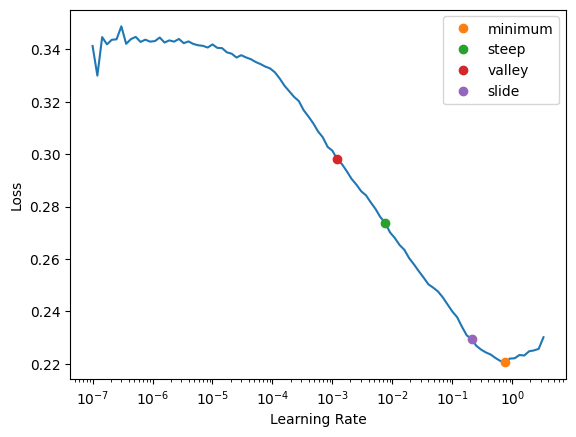

In [15]:
suggest_funcs = (minimum, steep, valley, slide)

lrs = learn.lr_find(suggest_funcs=suggest_funcs)

In [16]:
learn.fit_one_cycle(11, 0.005)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.305970,0.286478,0.687703,00:00
1,0.261481,0.260445,0.653188,00:00
2,0.235159,0.239806,0.622647,00:00
3,0.219471,0.225269,0.592170,00:00
4,0.207471,0.212682,0.578604,00:00
5,0.195809,0.203319,0.572850,00:00
6,0.185421,0.200830,0.565117,00:00
7,0.178575,0.200786,0.562419,00:00
8,0.171102,0.202894,0.571638,00:00
9,0.164985,0.208269,0.591094,00:00


In [17]:
preds, targs = learn.get_preds()
preds = preds.squeeze(1)

In [18]:
rmse(preds, targs)

TensorBase(0.4625)

In [19]:
test = pd.read_csv(path/'diabetes.csv')

In [20]:
test_dl = dls.test_dl(test)

In [21]:
preds, _ = learn.get_preds(dl=test_dl)
preds = preds.squeeze(1)

In [22]:



submit = pd.read_csv(path/'diabetes.csv')

submit['Outcome'] = preds


submit.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1.028913
1,1,85,66,29,0,26.6,0.351,31,0.235088
2,8,183,64,0,0,23.3,0.672,32,1.174040
3,1,89,66,23,94,28.1,0.167,21,0.160332
4,0,137,40,35,168,43.1,2.288,33,1.199171


In [23]:
submit.to_csv('submission.csv', index=False)

In [24]:
learn.export('model.pkl')